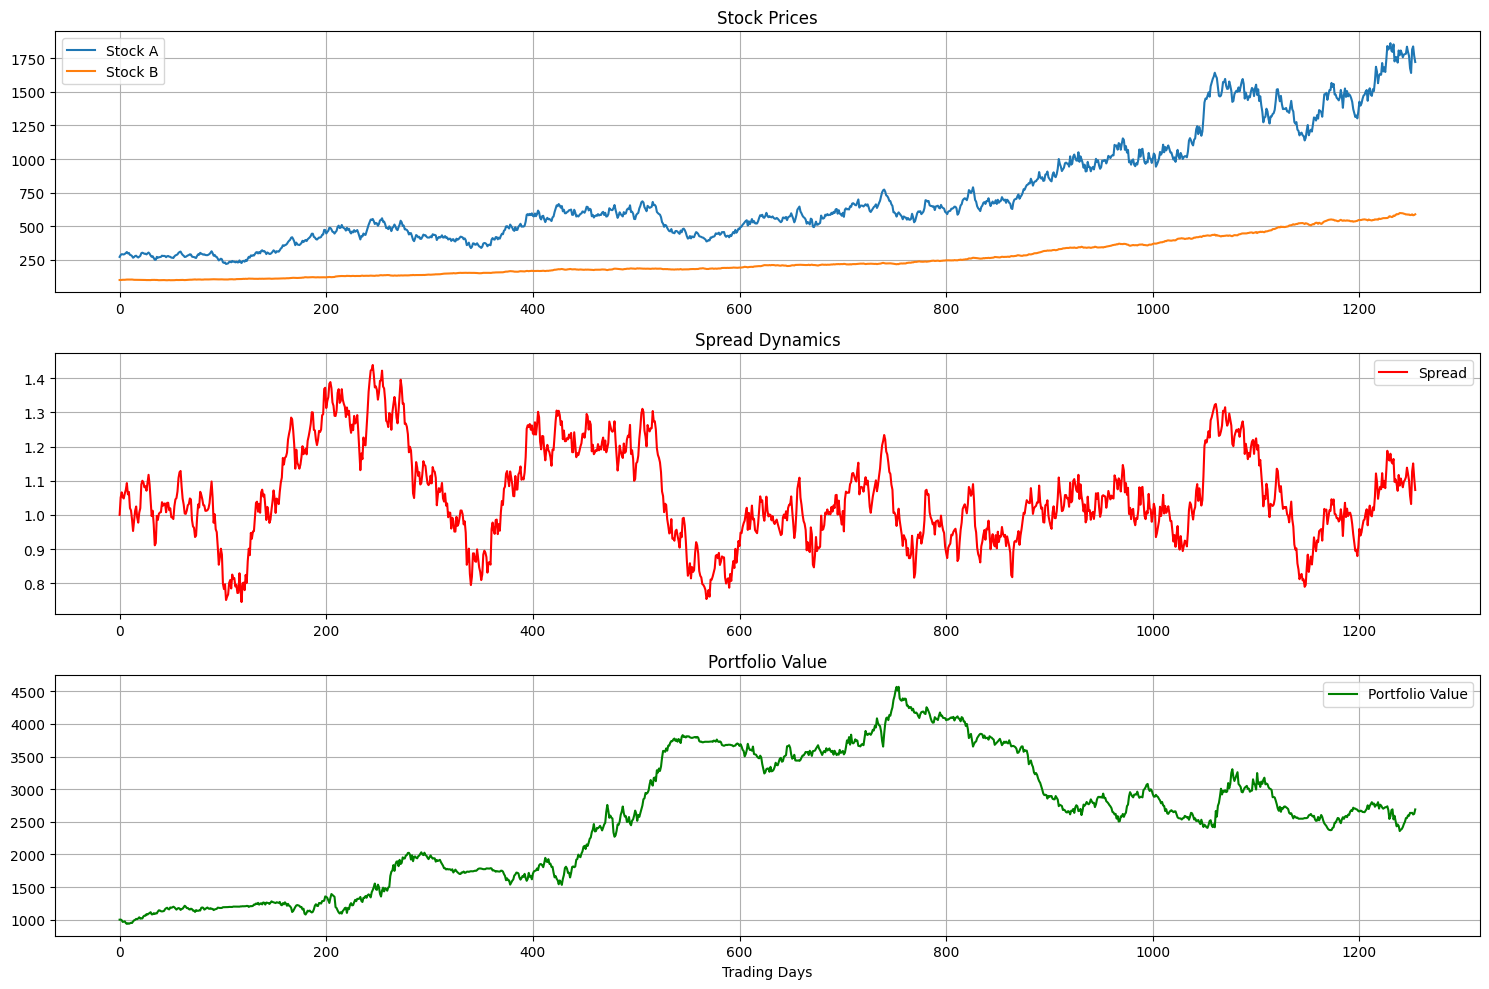

Final Portfolio Value: $2689.74
Yearly Return: 21.88%


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class OptimalPairsTrading:
    def __init__(self, k=5.0, theta=1.0, eta=0.5, mu=0.3, sigma=0.1, rho=0.19, r=0.02, gamma=-100.0):
        self.k = k  # Mean reversion rate
        self.theta = theta  # Long-term mean level of spread
        self.eta = eta  # Spread volatility
        self.mu = mu  # Drift of Stock B
        self.sigma = sigma  # Volatility of Stock B
        self.rho = rho  # Correlation between spreads and stock B noise
        self.r = r  # Risk-free rate
        self.gamma = gamma  # Risk aversion
        self.dt = 1 / 251  # Trading days in a year

    def simulate_prices(self, days: int, seed: int = None):
        if seed is not None:
            np.random.seed(seed)

        epsilon = np.random.randn(days)
        delta = self.rho * epsilon + np.sqrt(1 - self.rho**2) * np.random.randn(days)

        B_prices = np.zeros(days)
        spreads = np.zeros(days)
        B_prices[0] = 100  # Initial price of Stock B
        spreads[0] = 1.0  # Initial spread value

        for t in range(1, days):
            B_prices[t] = B_prices[t-1] * np.exp((self.mu - 0.5 * self.sigma**2) * self.dt + self.sigma * epsilon[t] * np.sqrt(self.dt))
            spreads[t] = (self.theta * (1 - np.exp(-self.k * self.dt)) +
                          np.exp(-self.k * self.dt) * spreads[t-1] +
                          self.eta * np.sqrt((1 - np.exp(-2 * self.k * self.dt)) / (2 * self.k)) * delta[t])

        A_prices = B_prices * np.exp(spreads)

        return pd.DataFrame({
            'stock_A': A_prices,
            'stock_B': B_prices,
            'spread': spreads
        })

    def calculate_alpha_beta(self, t, T):
        tau = T - t
        sqrt_term = (1 - self.gamma)**0.5
        exp_factor = np.exp(2 * self.k * tau * sqrt_term)

        # Calculate alpha(t)
        alpha = (self.k * (1 - sqrt_term)) / (2 * self.eta**2) * (
            1 + (2 * sqrt_term) / (1 - sqrt_term - (1 + sqrt_term) * exp_factor)
        )

        # Calculate beta(t)
        numerator = (
            self.gamma * sqrt_term * (self.eta**2 + 2 * self.rho * self.sigma * self.eta) * (1 - exp_factor)
            - self.gamma * (self.eta**2 + 2 * self.rho * self.sigma * self.eta + 2 * self.k * self.theta) * (1 - exp_factor)
        )
        denominator = (
            2 * self.eta**2 * (sqrt_term - (1 + sqrt_term) * exp_factor)
        )

        beta = numerator / denominator

        return alpha, beta

    def calculate_optimal_weight(self, x, t, T):
        alpha, beta = self.calculate_alpha_beta(t, T)

        # Optimal weight calculation based on Equation (28) in the paper
        h_star = (1 / (1 - self.gamma)) * (
            beta + 2 * x * alpha - (self.k * (x - self.theta) / self.eta**2) +
            (self.rho * self.sigma / self.eta) + 0.5
        )

        # Clip weights to prevent extreme values
        return np.clip(h_star, -10.0, 10.0)

    def run_backtest(self, initial_wealth=1000, days=1255, seed=42):
        data = self.simulate_prices(days, seed)

        portfolio_values = np.zeros(days)
        portfolio_values[0] = initial_wealth

        np.random.seed(seed)
        dW = np.random.randn(days) * np.sqrt(self.dt)

        T = days * self.dt

        for t in range(1, days):
            x_t = data.spread.iloc[t-1]
            h_star = self.calculate_optimal_weight(x_t, t * self.dt, T)

            # Wealth dynamics
            dV = portfolio_values[t-1] * (
                h_star * self.k * (self.theta - x_t) * self.dt +
                self.r * self.dt +
                h_star * self.eta * dW[t]
            )

            # Update portfolio value, ensuring no negative wealth
            portfolio_values[t] = max(portfolio_values[t-1] + dV, 0)

        return data, portfolio_values

def plot_results(data, portfolio_values):
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    plt.plot(data.stock_A, label="Stock A")
    plt.plot(data.stock_B, label="Stock B")
    plt.title("Stock Prices")
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(data.spread, label="Spread", color='red')
    plt.title("Spread Dynamics")
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(portfolio_values, 'g-', label="Portfolio Value")
    plt.title("Portfolio Value")
    plt.xlabel("Trading Days")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Final Portfolio Value: ${portfolio_values[-1]:.2f}")

    # Calculate yearly return
    years = len(portfolio_values) / 251
    yearly_return = ((portfolio_values[-1] / portfolio_values[0]) ** (1 / years) - 1) * 100
    print(f"Yearly Return: {yearly_return:.2f}%")

if __name__ == "__main__":
    strategy = OptimalPairsTrading()

    data, portfolio_values = strategy.run_backtest(days=1255, seed=42)

    plot_results(data, portfolio_values)


===== Backtest Performance Summary =====
Final Portfolio Value: $4610.90
Total Return: 361.09%
Annualized Return: 54.15%
Standard Deviation (Annualized): 0.5136
Sharpe Ratio: 1.02
Sortino Ratio: 1.39
RAROC: 1.05
Maximum Drawdown: -64.29%
Total Transaction Costs: $0.16
Number of Trades Executed: 889
Average Position Size: 1.3626
Top-performing Pair: ('BTC-USD', 'DB')
              Spread  Cumulative_PnL
Date                                
2024-10-25  8.283339     4638.287895
2024-10-28  8.314101     4610.130315
2024-10-29  8.361165     4552.629507
2024-10-30  8.370728     4535.862287
2024-10-31  8.329642     4610.901897


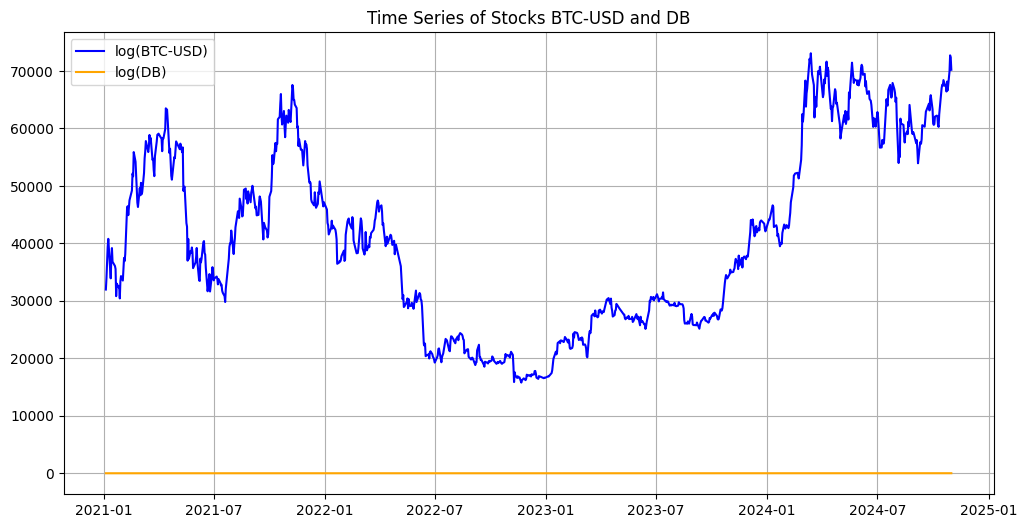

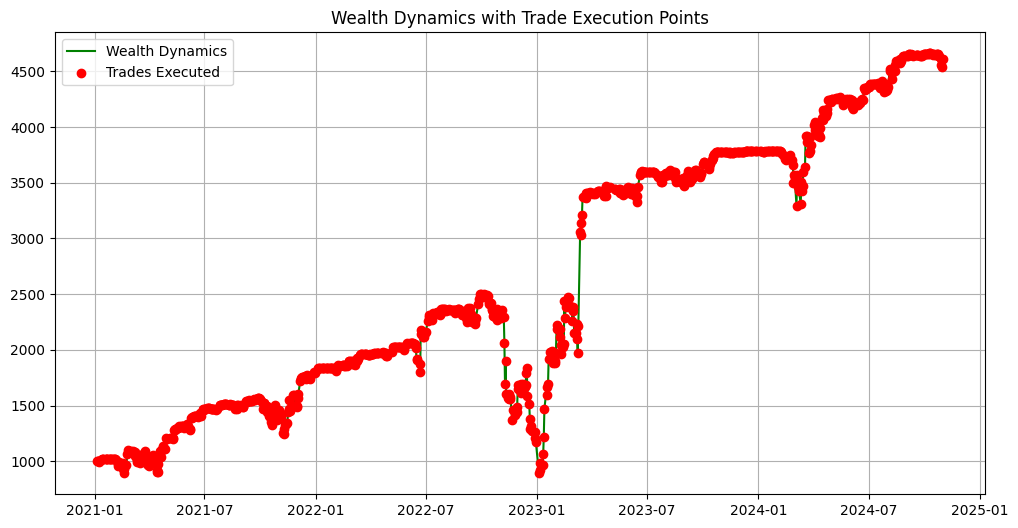

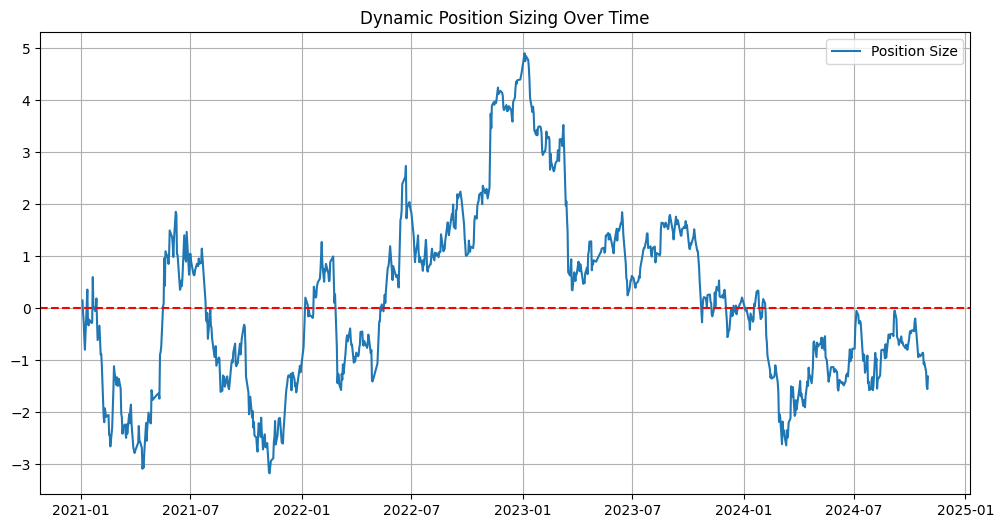

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
from itertools import combinations
from typing import List, Tuple

# Step 1: Fetch the universe of assets
def get_universe_tickers() -> List[str]:
    """
    Define the universe of assets: cryptocurrencies, bank stocks, and global indices.

    - This is the "asset universe" from which we select pairs for trading.
    - Selection of diversified assets increases the likelihood of finding cointegrated pairs.
    """
    crypto_forex_stocks = [
        'BTC-USD', 'ETH-USD', 'BNB-USD', 'XRP-USD', 'ADA-USD',
        'DOGE-USD', 'ETC-USD', 'XLM-USD', 'AAVE-USD', 'EOS-USD'
    ]
    bank_stocks = [
        'JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'DB', 'UBS', 'BBVA', 'SAN'
    ]
    global_indexes = ['^DJI', '^IXIC', '^GSPC', '^FTSE', '^N225']
    currency_pairs = [
        'EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCAD=X', 'AUDUSD=X',
        'USDCHF=X', 'NZDUSD=X', 'EURGBP=X', 'EURJPY=X', 'GBPJPY=X'
    ]
    return crypto_forex_stocks + bank_stocks + global_indexes + currency_pairs


# Step 2: Fetch historical price data
def fetch_price_data(tickers: List[str], start_date: str, end_date: str) -> pd.DataFrame:
    """
    Fetch historical adjusted close prices for the specified tickers using Yahoo Finance.

    - Price data forms the basis for spread calculation and pairs selection.
    - Missing data is dropped to ensure clean time series for analysis.
    """
    prices = pd.DataFrame()
    for ticker in tickers:
        try:
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)['Adj Close']
            if not data.empty:
                prices[ticker] = data
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
    return prices.dropna()

# Step 3: Identify cointegrated pairs
def find_cointegrated_pairs(prices: pd.DataFrame, significance_level: float = 0.1) -> List[Tuple]:
    """
    Identify pairs of assets that are cointegrated using the Engle-Granger test.

    - Cointegration ensures that the spread (log price difference) follows a mean-reverting process.
    - Pairs with a p-value below the significance level are selected.
    """
    pairs = []
    for ticker1, ticker2 in combinations(prices.columns, 2):
        _, p_value, _ = coint(prices[ticker1], prices[ticker2])
        if p_value < significance_level:
            pairs.append((ticker1, ticker2, p_value))
    return pairs

# Step 4: Estimate Ornstein-Uhlenbeck (OU) parameters
def estimate_ou_parameters(spread: pd.Series) -> Tuple[float, float, float]:
    """
    Estimate the parameters of the Ornstein-Uhlenbeck process for the spread:
        dX(t) = k(θ - X(t))dt + ηdW(t)
    where:
        θ (theta): Long-term mean of the spread.
        k       : Mean-reversion rate.
        η (eta) : Volatility of the spread.

    - Parameters are estimated by minimizing the residuals of the discrete OU equation.
    """
    delta = spread.diff().dropna()  # ΔX(t) = X(t) - X(t-1)
    lag_spread = spread.shift(1).dropna()  # X(t-1)

    def loss(params):
        theta, k = params
        residuals = delta - k * (theta - lag_spread)
        return np.sum(residuals ** 2)  # Minimize the squared residuals

    # Initial guess for theta and k
    result = minimize(loss, x0=[spread.mean(), 0.1], bounds=[(spread.min(), spread.max()), (1e-5, None)])
    theta, k = result.x  # Optimal theta and k
    eta = np.sqrt(np.var(delta - k * (theta - lag_spread)))  # Estimate η (spread volatility)
    return theta, k, eta

# Step 5: Calculate optimal weights based on OU parameters
def calculate_optimal_weights(theta: float, k: float, eta: float, spread: pd.Series) -> pd.Series:
    """
    Calculate the optimal position sizes (weights) based on the spread and OU parameters:
        h*(t) = k(θ - X(t)) / η^2

    - This follows the paper's optimal control formula for position sizing (Equation 28).
    """
    return k * (theta - spread) / eta**2

# Step 6: Backtest the pairs trading strategy
def backtest_strategy(prices: pd.DataFrame, pair: Tuple[str, str], initial_wealth: float = 1000,
                      transaction_cost: float = 0.001, risk_free_rate: float = 0.02) -> pd.DataFrame:
    """
    Backtest the pairs trading strategy with corrected position sizing and PnL calculations.
    Key changes:
    - Position sizing based on spread deviation from mean
    - Proper calculation of returns for long-short positions
    - Correct handling of the mean-reversion signal
    """
    ticker1, ticker2 = pair

    # Calculate log spread
    spread = np.log(prices[ticker1]) - np.log(prices[ticker2])

    # Get OU parameters
    theta, k, eta = estimate_ou_parameters(spread)

    # Calculate optimal weights based on mean reversion signal
    weights = calculate_optimal_weights(theta, k, eta, spread)

    portfolio = pd.DataFrame(index=spread.index)
    portfolio['Spread'] = spread
    portfolio['Weights'] = weights

    # Track position changes for transaction costs
    portfolio['Position_Change'] = weights.diff().abs()
    portfolio['Trades_Executed'] = portfolio['Position_Change'] > 1e-5

    # Calculate returns for each asset
    portfolio['Asset1_Returns'] = prices[ticker1].pct_change()
    portfolio['Asset2_Returns'] = prices[ticker2].pct_change()

    # Calculate PnL for the pairs trade
    # When spread > mean (theta): short asset1, long asset2
    # When spread < mean (theta): long asset1, short asset2
    portfolio['Signal'] = -(spread - theta)  # Negative sign because we want to go long when spread < theta
    portfolio['PnL'] = portfolio['Signal'].shift(1) * (portfolio['Asset1_Returns'] - portfolio['Asset2_Returns'])

    # Apply position sizing
    portfolio['PnL'] = portfolio['PnL'] * abs(weights.shift(1))

    # Transaction costs
    portfolio['Transaction_Cost'] = transaction_cost * portfolio['Position_Change']
    portfolio['Net_PnL'] = portfolio['PnL'] - portfolio['Transaction_Cost']

    # Calculate daily returns relative to portfolio value
    portfolio['Daily_Return'] = portfolio['Net_PnL']

    # Calculate cumulative wealth with compounding
    portfolio['Cumulative_PnL'] = initial_wealth * (1 + portfolio['Daily_Return']).cumprod()

    # Performance metrics
    final_wealth = portfolio['Cumulative_PnL'].iloc[-1]
    total_return = (final_wealth - initial_wealth) / initial_wealth
    trading_days = 252
    annualized_return = (1 + total_return) ** (trading_days / len(portfolio)) - 1

    # Risk metrics
    daily_returns = portfolio['Daily_Return'].dropna()
    excess_returns = daily_returns - risk_free_rate/trading_days
    standard_deviation = daily_returns.std() * np.sqrt(trading_days)
    downside_returns = daily_returns[daily_returns < 0]
    downside_deviation = downside_returns.std() * np.sqrt(trading_days) if len(downside_returns) > 0 else standard_deviation

    # Risk-adjusted return metrics
    sharpe_ratio = (annualized_return - risk_free_rate) / standard_deviation if standard_deviation != 0 else 0
    sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation if downside_deviation != 0 else 0
    raroc = annualized_return / standard_deviation if standard_deviation != 0 else 0

    # Add maximum drawdown calculation
    portfolio['Peak'] = portfolio['Cumulative_PnL'].cummax()
    portfolio['Drawdown'] = (portfolio['Cumulative_PnL'] - portfolio['Peak']) / portfolio['Peak']
    max_drawdown = portfolio['Drawdown'].min()

    print("===== Backtest Performance Summary =====")
    print(f"Final Portfolio Value: ${final_wealth:.2f}")
    print(f"Total Return: {total_return * 100:.2f}%")
    print(f"Annualized Return: {annualized_return * 100:.2f}%")
    print(f"Standard Deviation (Annualized): {standard_deviation:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Sortino Ratio: {sortino_ratio:.2f}")
    print(f"RAROC: {raroc:.2f}")
    print(f"Maximum Drawdown: {max_drawdown*100:.2f}%")
    print(f"Total Transaction Costs: ${portfolio['Transaction_Cost'].sum():.2f}")
    print(f"Number of Trades Executed: {int(portfolio['Trades_Executed'].sum())}")
    print(f"Average Position Size: {abs(portfolio['Weights']).mean():.4f}")
    print("========================================")

    return portfolio


# Step 7: Plot Time Series and Wealth Dynamics
def plot_results(prices: pd.DataFrame, portfolio: pd.DataFrame, pair: Tuple[str, str]):
    """
    Plot the time series of asset prices and wealth dynamics with trade execution points.
    """
    ticker1, ticker2 = pair

    # Time series of log prices
    plt.figure(figsize=(12, 6))
    plt.plot(prices[ticker1], label=f"log({ticker1})", color='blue')
    plt.plot(prices[ticker2], label=f"log({ticker2})", color='orange')
    plt.title(f"Time Series of Stocks {ticker1} and {ticker2}")
    plt.legend()
    plt.grid()
    plt.show()

    # Wealth dynamics with trade markers
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio['Cumulative_PnL'], label="Wealth Dynamics", color='green')
    trade_points = portfolio[portfolio['Trades_Executed']].index
    plt.scatter(trade_points, portfolio['Cumulative_PnL'][trade_points], color='red', label="Trades Executed", zorder=5)
    plt.title("Wealth Dynamics with Trade Execution Points")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(portfolio.index, portfolio['Weights'], label='Position Size')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Dynamic Position Sizing Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Step 8: Main execution
start_date = "2021-01-01"
end_date = "2024-11-01"

# Fetch the universe and price data
tickers = get_universe_tickers()
prices = fetch_price_data(tickers, start_date, end_date)

if not prices.empty:
    pairs = find_cointegrated_pairs(prices)
    if pairs:
        pair = pairs[0][:2]  # Select the first pair
        portfolio = backtest_strategy(prices, pair)
        print(f"Top-performing Pair: {pair}")
        print(portfolio[['Spread', 'Cumulative_PnL']].tail())
        plot_results(prices, portfolio, pair)
else:
    print("No price data available. Please check the tickers or time range.")
